In [17]:
#import libraries
import numpy as np              
import matplotlib.pyplot as plt  
import pandas as pd              
import tensorflow as tf
import pickle
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings("ignore") 

from tensorflow.keras.callbacks import  ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

***
### MODELING
*** 
With the previous models achieving a threshold of 80% we explored further usage of pretrained CNN architectures to better the accuracy of the model.
The following models were the best models we achieved.
1. Use of EfficientNetV2B0 architecture
2. Use of ResNet50 architecture


***
##### EFFICIENTNETV2B0 DATA AUGMENTATION
***

In [18]:
#ImageDataGenerator for training with augmentation
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# ImageDataGenerator for validation (without augmentation)
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
     
)

# ImageDataGenerator for testing (without augmentation)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
     
)

# Creating train, validation, and test image flows from data
train_data = train_generator.flow_from_directory(
    'RealWaste2/train',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

val_data = val_generator.flow_from_directory(
    'RealWaste2/val',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

test_data = test_generator.flow_from_directory(
    'RealWaste2/test',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3001 images belonging to 8 classes.
Found 857 images belonging to 8 classes.
Found 433 images belonging to 8 classes.


In [19]:

# Extract class indices from train_data
y_train = train_data.classes

# Compute class weights
cls_wt = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)

# Create a dictionary for class weights
class_weights = {i: cls_wt[i] for i in range(len(cls_wt))}

print(class_weights)

{0: 1.3070557491289199, 1: 1.27593537414966, 2: 0.6783453887884268, 3: 1.0841763005780347, 4: 1.0717857142857143, 5: 0.5824922360248447, 6: 1.6897522522522523, 7: 1.2299180327868853}



***
##### EFFICIENTNETV2B0 MODEL
***

In [21]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False
inputs = pretrained_model.input

# Add layers to the model
model = tf.keras.layers.Dense(90, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)
model = tf.keras.layers.Dense(180, activation='relu', kernel_regularizer=l2(0.001))(model)
outputs = tf.keras.layers.Dense(8, activation='softmax')(model)

model1 = tf.keras.Model(inputs=inputs, outputs=outputs)

# compiling the model
model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("efficientnetV2B0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [24]:
# Fitting the model
history1 = model1.fit(
    train_data,
    validation_data=val_data,
    batch_size = 32,
    epochs=12,
    class_weight=class_weights,
    callbacks=[checkpoint,reduce_lr])

Epoch 1/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9000 - loss: 0.4836
Epoch 1: val_accuracy improved from 0.79463 to 0.80280, saving model to efficientnetV2B0.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.9000 - loss: 0.4838 - val_accuracy: 0.8028 - val_loss: 0.7555 - learning_rate: 0.0010
Epoch 2/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8987 - loss: 0.4722
Epoch 2: val_accuracy improved from 0.80280 to 0.81330, saving model to efficientnetV2B0.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.8987 - loss: 0.4722 - val_accuracy: 0.8133 - val_loss: 0.7505 - learning_rate: 0.0010
Epoch 3/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9058 - loss: 0.4446
Epoch 3: val_accuracy improved from 0.81330 to 0.82964, saving model to efficientnetV2B0.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.9057 - loss: 0.4448 - val_accuracy: 0.8296 - val_loss: 0.7004 - learning_rate: 0.0010
Epoch 4/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/st

In [25]:
# Evaluating the Validation data
results = model1.evaluate(val_data, verbose=0)

print("    Validation Loss: {:.5f}".format(results[0]))
print("Validation Accuracy: {:.2f}%".format(results[1] * 100))

    Validation Loss: 0.62798
Validation Accuracy: 84.36%


In [26]:
# Obtain class names from the test data generator
class_names = list(test_data.class_indices.keys())

# Predict on the test data
predictions = model1.predict(test_data, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_data.classes

# Convert true labels to class names
true_labels_names = [class_names[label] for label in true_labels]

# Convert predicted labels to class names
predicted_labels_names = [class_names[label] for label in predicted_classes]

# Print classification report
print(classification_report(true_labels_names, predicted_labels_names, target_names=class_names))


14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step 
                     precision    recall  f1-score   support

      Food Organics       0.88      0.88      0.88        42
              Glass       0.71      0.86      0.77        42
              Metal       0.73      0.96      0.83        79
Miscellaneous Trash       0.86      0.60      0.71        50
              Paper       0.98      0.86      0.91        50
            Plastic       0.85      0.73      0.79        93
      Textile Trash       0.85      0.88      0.87        33
         Vegetation       0.98      0.95      0.97        44

           accuracy                           0.83       433
          macro avg       0.85      0.84      0.84       433
       weighted avg       0.85      0.83      0.83       433



<Figure size 1000x800 with 0 Axes>

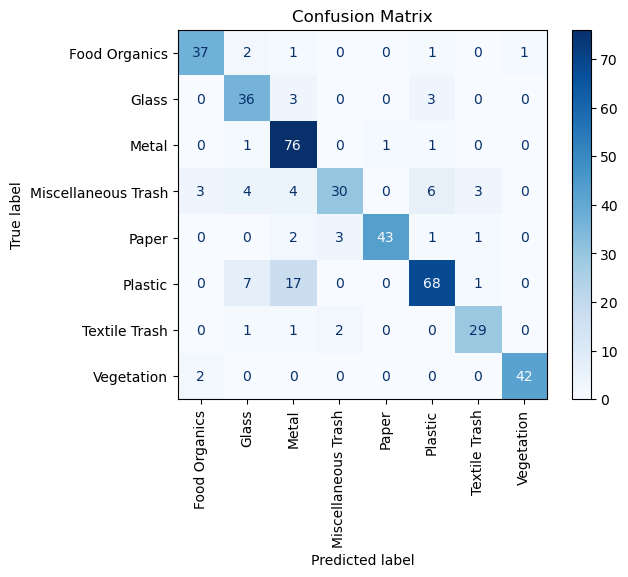

In [27]:

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes, labels=np.arange(len(class_names)))

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

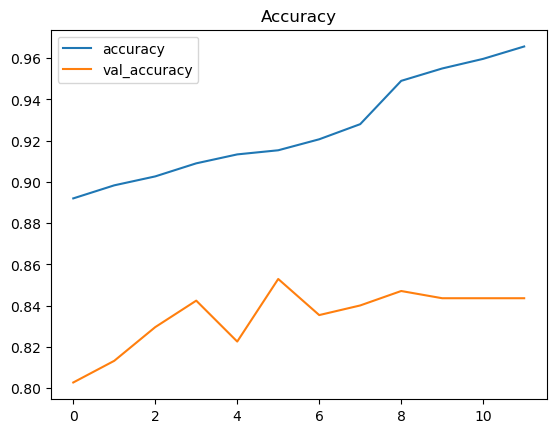

In [28]:
# Plotting for accuracy in the model
pd.DataFrame(history1.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

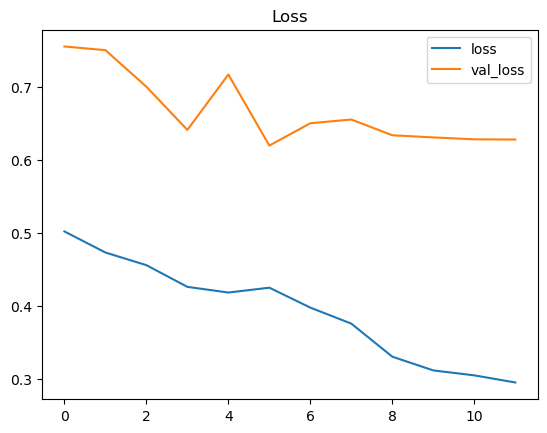

In [29]:
#Plotting for Loss in the Model
pd.DataFrame(history1.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [30]:
# Saving the model into a pickle
with open('pickle_files/models/model1.pkl', 'wb') as file:
    pickle.dump(model, file)

***
Findings and Observations
***

- This model was able to achieve the desired metrics of of which it achieved 83% accuracy and 83% F1 score.
- The F1 score used was weighted as the classes had been weighted to account for the class imbalance.
- It is evident that classes generalize well to their classes except miscellaneous trash which has an F1 score of 71%.
- The models begin to plateau after 10 epochs in both the accuracy and loss


***
##### RESNET50 DATA AUGMENTATION
***

In [ ]:
# ImageDataGenerator for training with augmentation
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# ImageDataGenerator for validation (without augmentation)
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

# ImageDataGenerator for testing (without augmentation)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

# Creating train, validation, and test image flows from directories
train_data = train_generator.flow_from_directory(
    'RealWaste2/train',
    target_size=(224, 224),  
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

val_data = val_generator.flow_from_directory(
    'RealWaste2/val',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

test_data = test_generator.flow_from_directory(
    'RealWaste2/test',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

In [ ]:

# Extract class indices from train_data
y_train = train_data.classes

# Compute class weights
cls_wt = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)

# Create a dictionary for class weights
class_weights = {i: cls_wt[i] for i in range(len(cls_wt))}

print(class_weights)


***
##### RESNET50 MODEL
***

In [ ]:
# Load the pretrained model
pretrained_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

inputs = pretrained_model.input

# Add layers to the model
x = tf.keras.layers.Dense(180, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)
x = tf.keras.layers.Dense(360, activation='relu', kernel_regularizer=l2(0.001))(x)
outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint("resnet50.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [2]:

# Train the model with class weights
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    class_weight=class_weights,
    callbacks=[checkpoint, reduce_lr]
)


Found 3001 images belonging to 8 classes.
Found 857 images belonging to 8 classes.
Found 433 images belonging to 8 classes.
{0: 1.3070557491289199, 1: 1.27593537414966, 2: 0.6783453887884268, 3: 1.0841763005780347, 4: 1.0717857142857143, 5: 0.5824922360248447, 6: 1.6897522522522523, 7: 1.2299180327868853}
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5303 - loss: 1.7318
Epoch 1: val_accuracy improved from -inf to 0.75963, saving model to resnet50.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 334s 3s/step - accuracy: 0.5315 - loss: 1.7286 - val_accuracy: 0.7596 - val_loss: 1.1323 - learning_rate: 0.0010
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7974 - loss: 0.9492
Epoch 2: val_accuracy improved from 0.75963 to 0.78063, saving model to resnet50.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.7973 - loss: 0.9490 - val_accuracy: 0.7806 - val_loss: 1.0064 - learning_rate: 0.0010
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8287 - loss: 

In [3]:
results = model.evaluate(val_data, verbose=0)

print("    Validation Loss: {:.5f}".format(results[0]))
print("Validation Accuracy: {:.2f}%".format(results[1] * 100))

    Validation Loss: 0.64626
Validation Accuracy: 86.93%


In [5]:
# Obtain class names from the test data generator
class_names = list(test_data.class_indices.keys())

# Predict on the test data
predictions = model.predict(test_data, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_data.classes

# Convert true labels to class names
true_labels_names = [class_names[label] for label in true_labels]

# Convert predicted labels to class names
predicted_labels_names = [class_names[label] for label in predicted_classes]

# Print classification report
print(classification_report(true_labels_names, predicted_labels_names, target_names=class_names))


14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step
                     precision    recall  f1-score   support

      Food Organics       0.89      0.98      0.93        42
              Glass       0.81      0.81      0.81        42
              Metal       0.78      0.90      0.84        79
Miscellaneous Trash       0.78      0.64      0.70        50
              Paper       0.86      0.88      0.87        50
            Plastic       0.88      0.78      0.83        93
      Textile Trash       0.85      0.88      0.87        33
         Vegetation       0.96      0.98      0.97        44

           accuracy                           0.85       433
          macro avg       0.85      0.86      0.85       433
       weighted avg       0.85      0.85      0.85       433



<Figure size 1000x800 with 0 Axes>

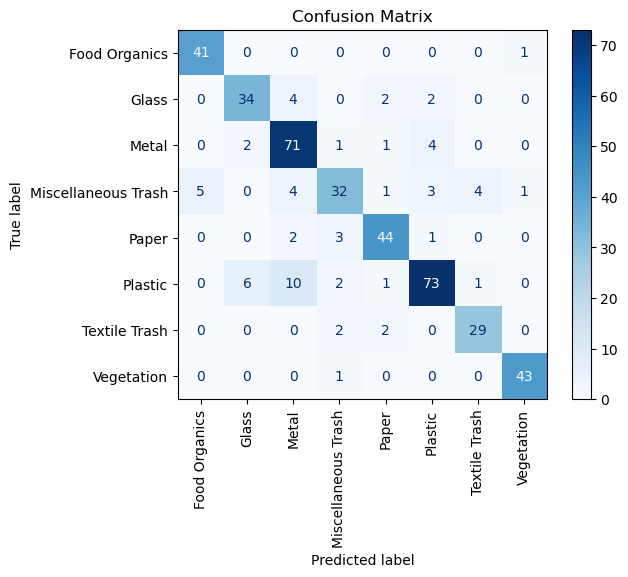

In [6]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes, labels=np.arange(len(class_names)))

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

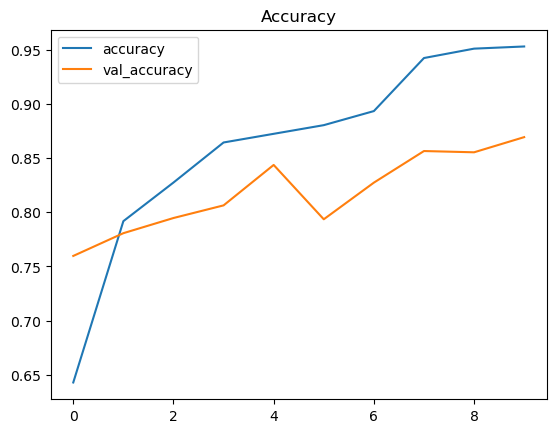

In [7]:
# Plotting for accuracy in the model
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

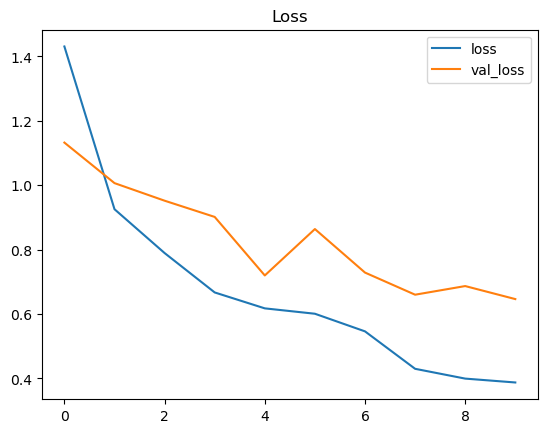

In [8]:
# Plotting for loss in the model
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [9]:
# Saving the model into a pickle
with open('pickle_files/models/resnet50.pkl', 'wb') as file:
    pickle.dump(model, file)

***
Findings and Observations
***
- ResNet50 CNN architecture was able to give us the best model with an accuracy of 85% and an F1 score of 85%
- The F1 score used was weighted as the classes had been weighted to account for the class imbalance.
- Plastics classification was greatly improved to 83% while most of the other models remianed constant or showed better improvement